In [23]:
import os, shutil
from PIL import Image, ImageOps

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras import models, layers, optimizers, regularizers
from tensorflow.keras import Model
from tensorflow.data.experimental import cardinality
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

---
# Deforestation Classification Using Satellite Imagery

---
## 1. Introduction

I am using a public dataset from Kaggle, which can be found [HERE](https://www.kaggle.com/datasets/waseemalastal/eurosat-rgb-dataset).


Deforestation is a major environmental issue that threatens biodiversity, contributes to climate change, and disrupts ecosystems. Monitoring and analyzing land cover changes over time is crucial for identifying areas at risk and implementing conservation strategies.  

With advancements in deep learning and computer vision, satellite imagery has become a powerful tool for detecting deforestation patterns. By using convolutional neural networks (CNNs), we can classify land cover types, track forest loss, and provide early warnings of encroaching development.  

This project focuses on building an automated classification model that processes satellite images to distinguish between different land cover categories. By identifying regions undergoing deforestation, the model can help environmental organizations, policymakers, and researchers make data-driven decisions to protect vital ecosystms.  


---
## 2. Import Data and Train Validation Test Split

This dataset contains 6000 RGB Satellite Images across 3 classes:

**Forest**

**Herbaceous Vegetation**

**Pasture**

There are about 2000 images per class.

The data is pre-divided into folders: **80%** train, **20%** test and **10%** of the train set is used for validation.

In [24]:
train_folder = "data/train"
test_folder = "data/test"

train_gen = ImageDataGenerator(rescale=1./255, validation_split = 0.125)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(train_folder,
                                                class_mode = 'categorical', 
                                                subset ='training', 
                                                batch_size=128,
                                                shuffle=True,
                                                seed=42)
                                               
val_generator= train_gen.flow_from_directory(train_folder,
                                             class_mode= 'categorical',
                                             subset = "validation",
                                             batch_size=128,
                                             shuffle=True,
                                             seed=42)

test_generator= test_gen.flow_from_directory(test_folder,
                                              class_mode= 'categorical',
                                              batch_size=128,
                                              shuffle=False,
                                              seed=42)

Found 4200 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 1200 images belonging to 3 classes.


### Create the data sets

In [25]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

### Explore Data

Let's look at our image counts of each class across the train, validation, and test datasets.

In [26]:
train_classes = train_generator.classes
val_classes = val_generator.classes
test_classes = test_generator.classes

train_class, train_count = np.unique(train_classes, return_counts=True)
val_class, val_count = np.unique(val_classes, return_counts=True)
test_class, test_count = np.unique(test_classes, return_counts=True)

print('Train ~ {}'.format(list(zip(train_class, train_count))))
print('Validation ~ {}'.format(list(zip(val_class, val_count))))
print('Test ~ {}'.format(list(zip(test_class, test_count))))

Train ~ [(0, 1400), (1, 1400), (2, 1400)]
Validation ~ [(0, 200), (1, 200), (2, 200)]
Test ~ [(0, 400), (1, 400), (2, 400)]


In [27]:
train_class_names = train_generator.class_indices
print('Train:', train_class_names)
val_class_names = val_generator.class_indices
print('Validation:', val_class_names)
test_class_names = test_generator.class_indices
print('Train:', test_class_names)

Train: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}
Validation: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}
Train: {'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}


### Preview the shape of both the images and labels for both the train, validation, and test sets

In [28]:
print("Train")
print(np.shape(train_images))
print(np.shape(train_labels))
print("Validation")
print(np.shape(val_images))
print(np.shape(val_labels))
print("Test")
print(np.shape(test_images))
print(np.shape(test_labels))

Train
(128, 256, 256, 3)
(128, 3)
Validation
(128, 256, 256, 3)
(128, 3)
Test
(128, 256, 256, 3)
(128, 3)


### Preview a train data image

[0. 1. 0.]


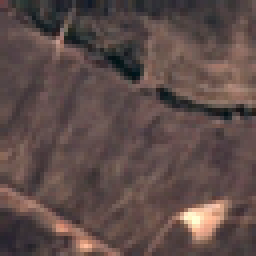

In [29]:
print(train_labels[0])
array_to_img(train_images[0])

### Preview a test data image

[1. 0. 0.]


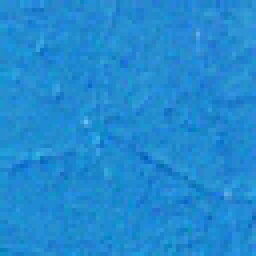

In [30]:
print(test_labels[0])
array_to_img(test_images[0])

---
## 3. Formulas

### --- Convolution (Conv2D Layer)
The formula for computing the filter (kernel) values in the convolutional layer:

$$
O(i, j) = \sum_{m=0}^{K-1} \sum_{n=0}^{K-1} I(i+m, j+n) \cdot W(m, n) + b
$$

The output size of the feature map is computed as:

$$
H_{\text{out}} = \frac{H_{\text{in}} - K + 2P}{S} + 1
$$

$$
W_{\text{out}} = \frac{W_{\text{in}} - K + 2P}{S} + 1
$$

### --- Max Pooling (MaxPooling2D Layer)
The max pooling operation selects the maximum value from a window of size \( P \times P \):

$$
O(i, j) = \max_{m=0}^{P-1} \max_{n=0}^{P-1} I(Si + m, Sj + n)
$$

The output size after max pooling is:

$$
H_{\text{out}} = \frac{H_{\text{in}} - P}{S} + 1
$$

$$
W_{\text{out}} = \frac{W_{\text{in}} - P}{S} + 1
$$

### --- Flattening (Flatten Layer)
Flattening simply reshapes the multi-dimensional tensor into a 1D vector:

$$
O = \text{Flatten}(I)
$$

### --- Fully Connected Layer (Dense Layer)
A fully connected layer (Dense layer) performs the following operation:

$$
O = \sigma(W \cdot I + b)
$$

For the **ReLU activation function**:

$$
\sigma(x) = \max(0, x)
$$

For the **softmax activation function** (used in the output layer):

$$
\sigma(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{N} e^{x_j}}
$$

## --- Loss Function (Categorical Crossentropy)
Since this is a multi-class classification problem, we use categorical crossentropy as the loss function:

$$
L = -\sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$

## --- Optimization (Adam Optimizer)
The Adam optimizer updates weights using:

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$

$$
W_t = W_{t-1} - \frac{\alpha \hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}
$$

### --- Loss Function (Categorical Crossentropy)
In the code, **`val_loss`** is used as a criterion for early stopping. Since the model is for **multi-class classification**, the loss function used is **categorical crossentropy**:

$$
L = -\sum_{i=1}^{N} y_i \log(\hat{y}_i)
$$

### --- Early Stopping Criterion
Early stopping monitors **`val_loss`**. If it does not improve for a specified number of epochs, training is stopped.

Mathematically:

$$
\Delta L_{\text{val}} = L_{\text{val}}^{(t)} - L_{\text{val}}^{(t-1)}
$$

If:

$$
\Delta L_{\text{val}} \geq 0, \quad \text{for } \text{patience} \text{ consecutive epochs}
$$

### --- Weight Update (Backpropagation with Adam Optimizer)
The model updates the weights using the **Adam optimizer**, which combines **gradient descent with momentum**:

- First moment (computing the moving average of the gradient):

$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t
$$

- Second moment (computing the moving average of the squared gradient):

$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2
$$

- Bias-corrected estimates:

$$
\hat{m_t} = \frac{m_t}{1 - \beta_1^t}
$$

$$
\hat{v_t} = \frac{v_t}{1 - \beta_2^t}
$$

- Final weight update:

$$
W_t = W_{t-1} - \frac{\alpha \hat{m_t}}{\sqrt{\hat{v_t}} + \epsilon}
$$

### --- Batch Training Process

$$
\text{Iterations per epoch} = \frac{\text{Total training samples}}{\text{Batch size}}
$$

### --- Accuracy Calculation
The accuracy is computed as the percentage of correctly classified test samples:

$$
\text{Accuracy} = \frac{\text{Number of correctly predicted labels}}{\text{Total number of test samples}} \times 100
$$

Or mathematically:

$$
\text{Accuracy} = \frac{1}{M} \sum_{i=1}^{M} \mathbb{1}(\hat{y}_i = y_i)
$$

---
## 4. Modeling

---
### Model 1

Let's make our CNN "deeper" and add additonal convolution and max pooling layers.

In [34]:
model_one = Sequential()

model_one.add(Input(shape=(256, 256, 3)))
model_one.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_one.add(MaxPooling2D(pool_size=(2, 2)))

model_one.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_one.add(layers.MaxPooling2D((2, 2)))

model_one.add(Flatten())
model_one.add(Dense(64, activation='relu'))

model_one.add(Dense(3, activation='softmax'))

model_one.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_one.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,882,915 (30.07 MB)

 Trainable params: 7,882,915 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

Let's also add a stopping criteria as well.

In [35]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_one_history = model_one.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.3655 - loss: 3.2475 - val_accuracy: 0.6233 - val_loss: 0.7850
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 650s 20s/step - accuracy: 0.6217 - loss: 0.7398 - val_accuracy: 0.6850 - val_loss: 0.5797
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7225 - loss: 0.5704 - val_accuracy: 0.7917 - val_loss: 0.5226
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7748 - loss: 0.5253 - val_accuracy: 0.8117 - val_loss: 0.5015
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7901 - loss: 0.4945 - val_accuracy: 0.8250 - val_loss: 0.4803
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7892 - loss: 0.5180 - val_accuracy: 0.7683 - val_loss: 0.5111
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.8206 - loss: 0.5127 - val_accuracy: 0.7483 - val_loss: 0.4856
Epoch 7: early stopping


In [36]:
test_loss, test_acc = model_one.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step - accuracy: 0.8595 - loss: 0.3296
Test loss:  0.5183432698249817
Test accuracy:  0.7425000071525574


We extended the model and added Early Stopping. The model stopped after 7 epochs when the validation loss stopped decreasing.

Our model shows a slight form of overfitting, but it is still within acceptable limits, achieving 82.1% accuracy on the training data and 74.2% accuracy on the test data.

---
### Model 2- L1 Regularization

#### Adding Regularization

To help with the consistent overfitting, let's try out a few regularization techniques: L1, L2, and Dropout Layers.

#### --- L1 Regularization Term
$$
R(W) = \lambda \sum_{i} |W_i|
$$

#### --- Modified Loss Function with L1 Regularization
$$
L_{\text{total}} = L_{\text{crossentropy}} + R(W)
$$

Expanding:

$$
L_{\text{total}} = -\sum_{i=1}^{N} y_i \log(\hat{y}_i) + \lambda \sum_{i} |W_i|
$$

#### --- Effect on Weight Update in Backpropagation

$$
W_t = W_{t-1} - \alpha \left( \frac{\partial L}{\partial W} + \lambda \cdot \text{sign}(W) \right)
$$

In [37]:
model_l1 = Sequential()

model_l1.add(Input(shape=(256, 256, 3)))
model_l1.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                     kernel_regularizer=regularizers.l1(0.005)))

model_l1.add(MaxPooling2D(pool_size=(2, 2)))

model_l1.add(layers.Conv2D(32, (3, 3), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l1(0.005)))

model_l1.add(layers.MaxPooling2D((2, 2)))

model_l1.add(Flatten())
model_l1.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l1(0.005)))

model_l1.add(Dense(3, activation='softmax'))

model_l1.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_l1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,882,915 (30.07 MB)

 Trainable params: 7,882,915 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_l1_history = model_l1.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

In [39]:
test_loss, test_acc = model_l1.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.7895 - loss: 5.6057
Test loss:  5.565722942352295
Test accuracy:  0.8174999952316284


The model demonstrates stable performance with Train Accuracy 78.4%, Validation Accuracy 82.7%, and Test Accuracy 81.75%, indicating that it does not suffer from severe overfitting.

---
### Model 3- L2 Regularization

#### --- L2 Regularization Term

$$
R(W) = \lambda \sum_{i} W_i^2
$$

#### --- Modified Loss Function with L2 Regularization
$$
L_{\text{total}} = L_{\text{crossentropy}} + R(W)
$$

Expanding:

$$
L_{\text{total}} = -\sum_{i=1}^{N} y_i \log(\hat{y}_i) + \lambda \sum_{i} W_i^2
$$

#### --- Effect on Weight Update in Backpropagation

$$
W_t = W_{t-1} - \alpha \left( \frac{\partial L}{\partial W} + 2\lambda W \right)
$$

In [40]:
model_l2 = Sequential()

model_l2.add(Input(shape=(256, 256, 3)))
model_l2.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                     kernel_regularizer=regularizers.l2(0.005)))

model_l2.add(MaxPooling2D(pool_size=(2, 2)))

model_l2.add(layers.Conv2D(32, (3, 3), 
                            activation='relu', 
                            kernel_regularizer=regularizers.l2(0.005)))

model_l2.add(layers.MaxPooling2D((2, 2)))

model_l2.add(Flatten())
model_l2.add(Dense(64, 
                    activation='relu', 
                    kernel_regularizer=regularizers.l2(0.005)))

model_l2.add(Dense(3, activation='softmax'))

model_l2.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_l2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,882,915 (30.07 MB)

 Trainable params: 7,882,915 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_l2_history = model_l2.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.5219 - loss: 2.4259 - val_accuracy: 0.7717 - val_loss: 1.0142
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 970ms/step - accuracy: 0.8171 - loss: 0.9009 - val_accuracy: 0.8633 - val_loss: 0.6721
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 991ms/step - accuracy: 0.8577 - loss: 0.6394 - val_accuracy: 0.8800 - val_loss: 0.5932
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 981ms/step - accuracy: 0.8595 - loss: 0.5529 - val_accuracy: 0.8717 - val_loss: 0.5098
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8889 - loss: 0.4702 - val_accuracy: 0.8783 - val_loss: 0.5115
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 996ms/step - accuracy: 0.8791 - loss: 0.4784 - val_accuracy: 0.8467 - val_loss: 0.4862
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8876 - loss: 0.4436 - val_accuracy: 0.8900 - val_loss: 0.4278
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 857s 27s/step - accuracy: 0.8986 - loss: 0.4063 - val_accuracy: 0.90

In [42]:
test_loss, test_acc = model_l2.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.8712 - loss: 0.3826
Test loss:  0.3502896726131439
Test accuracy:  0.8966666460037231


Compared to L1 regularization, L2 regularization worked much better on overfitting and even gave us a higher validation 88.8% and test 89.7% accuracy after only 19 epochs. 

---
### Model 4- Dropout Regularization

#### --- Dropout Regularization
Unlike the previous models, `model_dropout` applies **Dropout regularization**, which randomly deactivates neurons during training to prevent overfitting.

The probability of keeping a neuron **active** is:

$$
p_{\text{keep}} = 1 - p_{\text{drop}}
$$

During training, each neuron output \( a_i \) is scaled by **multiplying with a dropout mask \( M \)**:

$$
\tilde{a}_i = M_i \cdot a_i
$$

#### --- Dropout Effect During Inference
At **inference time (testing/prediction)**, we do not apply dropout but instead scale the activations to compensate for missing neurons during training:

$$
\hat{a}_i = p_{\text{keep}} \cdot a_i
$$

### --- Modified Backpropagation with Dropout
Dropout affects backpropagation by modifying the gradient update. The standard weight update rule:

$$
W_t = W_{t-1} - \alpha \frac{\partial L}{\partial W}
$$

is adjusted to:

$$
W_t = W_{t-1} - \alpha \left( p_{\text{keep}} \frac{\partial L}{\partial W} \right)
$$

In [43]:
model_dropout = Sequential()

model_dropout.add(Input(shape=(256, 256, 3)))
model_dropout.add(layers.Dropout(0.2))

model_dropout.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_dropout.add(MaxPooling2D(pool_size=(2, 2)))

model_dropout.add(layers.Dropout(0.2))

model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Dropout(0.2))

model_dropout.add(Flatten())
model_dropout.add(Dense(64, activation='relu'))

model_dropout.add(layers.Dropout(0.2))

model_dropout.add(Dense(3, activation='softmax'))

model_dropout.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_dropout.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,882,915 (30.07 MB)

 Trainable params: 7,882,915 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_dropout_history = model_dropout.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1154s 1s/step - accuracy: 0.3353 - loss: 3.1802 - val_accuracy: 0.6767 - val_loss: 1.0143
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4092 - loss: 0.8948 - val_accuracy: 0.7533 - val_loss: 0.6151
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7880 - loss: 0.5313 - val_accuracy: 0.7450 - val_loss: 0.5986
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.7981 - loss: 0.5104 - val_accuracy: 0.7717 - val_loss: 0.5428
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.8165 - loss: 0.4645 - val_accuracy: 0.7617 - val_loss: 0.5447
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8139 - loss: 0.4802 - val_accuracy: 0.7733 - val_loss: 0.5304
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8079 - loss: 0.4510 - val_accuracy: 0.7983 - val_loss: 0.4983
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8276 - loss: 0.4350 - val_accuracy: 0.7817 - val_lo

In [45]:
test_loss, test_acc = model_dropout.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step - accuracy: 0.8970 - loss: 0.3213
Test loss:  0.5184347033500671
Test accuracy:  0.7891666889190674


Dropout seemed to work the second best 78.9% Test accuracy, but also stopped after 9 Epochs.

---
### Model 5- Dropout and L2 Regularization

Droput and L2 were the better two regularization techniques; let's see what happens when we use them together.

In [46]:
model_v5 = Sequential()

model_v5.add(Input(shape=(256, 256, 3)))
model_v5.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu',
                     kernel_regularizer=regularizers.l2(0.005)))

model_v5.add(MaxPooling2D(pool_size=(2, 2)))
model_v5.add(layers.Dropout(0.2))

model_v5.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))

model_v5.add(layers.MaxPooling2D((2, 2)))
model_v5.add(layers.Dropout(0.2))

model_v5.add(Flatten())
model_v5.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

model_v5.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))

model_v5.add(Dense(3, activation='softmax'))

model_v5.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v5.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 32)                  │       3,936,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,948,739 (15.06 MB)

 Trainable params: 3,948,739 (15.06 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_v5_history = model_v5.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4668 - loss: 2.0107 - val_accuracy: 0.6933 - val_loss: 1.2229
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8117 - loss: 0.9396 - val_accuracy: 0.8250 - val_loss: 0.8372
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8488 - loss: 0.7437 - val_accuracy: 0.8950 - val_loss: 0.6903
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8823 - loss: 0.6251 - val_accuracy: 0.8717 - val_loss: 0.6137
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8766 - loss: 0.5474 - val_accuracy: 0.8650 - val_loss: 0.5643
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8946 - loss: 0.4991 - val_accuracy: 0.8850 - val_loss: 0.5613
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8864 - loss: 0.5030 - val_accuracy: 0.9017 - val_loss: 0.5065
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9055 - loss: 0.4598 - val_accuracy: 0.8683 - val_loss:

In [48]:
test_loss, test_acc = model_v5.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - accuracy: 0.9286 - loss: 0.3338
Test loss:  0.38811740279197693
Test accuracy:  0.9166666865348816


Overfitting is very low on this model, but all these regularization techniques seem to lower our accuracy below our baseline model's accuracy.

---
### Model 6- Increasing initial Convolution Layer's Filter and Kernal size.

#### --- Convolution Operation for a Larger Kernel
$$
O(i, j) = \sum_{m=0}^{K-1} \sum_{n=0}^{K-1} I(i+m, j+n) \cdot W(m, n) + b
$$

The output size of the feature map is computed as:

$$
H_{\text{out}} = \frac{H_{\text{in}} - K + 2P}{S} + 1
$$

$$
W_{\text{out}} = \frac{W_{\text{in}} - K + 2P}{S} + 1
$$

#### --- Neural Activation in Additional Dense Layer
Each neuron in the additional Dense layer performs:

$$
O = \sigma(W \cdot I + b)
$$

Let's try a restructure of our 2 Conv2d Layer model. Also we'll arrange our Dense layers by decreasing number of nodes.

In [49]:
model_v6 = Sequential()

model_v6.add(Input(shape=(256, 256, 3)))
model_v6.add(Conv2D(filters=64,
                          kernel_size=(5, 5),
                          activation='relu'))

model_v6.add(MaxPooling2D(pool_size=(2, 2)))
 
model_v6.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v6.add(layers.MaxPooling2D((2, 2)))

model_v6.add(Flatten())
model_v6.add(Dense(64, activation='relu'))

model_v6.add(Dense(32, activation='relu'))

model_v6.add(Dense(3, activation='softmax'))

model_v6.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v6.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 252, 252, 64)        │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 126, 126, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 124, 124, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 64)                  │       7,872,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,898,083 (30.13 MB)

 Trainable params: 7,898,083 (30.13 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_v6_history = model_v6.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4631 - loss: 1.3436 - val_accuracy: 0.8350 - val_loss: 0.5125
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8241 - loss: 0.4515 - val_accuracy: 0.8117 - val_loss: 0.4073
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8380 - loss: 0.3937 - val_accuracy: 0.7983 - val_loss: 0.4252
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8618 - loss: 0.3643 - val_accuracy: 0.8717 - val_loss: 0.3125
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8979 - loss: 0.2763 - val_accuracy: 0.9150 - val_loss: 0.2853
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8996 - loss: 0.2642 - val_accuracy: 0.9117 - val_loss: 0.2714
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8757 - loss: 0.3262 - val_accuracy: 0.8933 - val_loss: 0.2696
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9011 - loss: 0.2614 - val_accuracy: 0.8983 - val_loss:

In [51]:
test_loss, test_acc = model_v6.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.9392 - loss: 0.1625
Test loss:  0.1944762021303177
Test accuracy:  0.9266666769981384


Changing our Conv2D layer's kernal size and the number of filters seem to negatively affect our accuracy. We will go back to our 32 filters and (3,3) kernal next.

---
### Model 7- Add Dense(128) Layer 

#### --- Neural Activation in Multiple Dense Layers
Each neuron in the additional Dense layers follows the standard neural activation formula:

$$
O = \sigma(W \cdot I + b)
$$

With multiple dense layers, the feature transformation happens in a more hierarchical manner:

$$
O_1 = \sigma(W_1 \cdot I + b_1)
$$
$$
O_2 = \sigma(W_2 \cdot O_1 + b_2)
$$
$$
O_3 = \sigma(W_3 \cdot O_2 + b_3)
$$

#### --- Formula for Dense Layer Parameters
The number of parameters in a Dense layer is:

$$
\text{Params} = (\text{Input neurons} \times \text{Output neurons}) + \text{Bias neurons}
$$

#### --- Potential Overfitting Risk Due to Extra Fully Connected Layers
The risk of **overfitting** increases because of the large number of parameters.

The model complexity is quantified using **Vapnik-Chervonenkis (VC) dimension**:

$$
VC(\text{model}) \approx \sum (\text{parameters})
$$

In [52]:
model_v7 = Sequential()

model_v7.add(Input(shape=(256, 256, 3)))
model_v7.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_v7.add(MaxPooling2D(pool_size=(2, 2)))

model_v7.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v7.add(layers.MaxPooling2D((2, 2)))

model_v7.add(Flatten())
model_v7.add(Dense(128, activation='relu'))                
                             
model_v7.add(Dense(64, activation='relu'))
                
# Layer 6- dense layer  
model_v7.add(Dense(32, activation='relu'))

model_v7.add(Dense(3, activation='softmax'))

model_v7.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v7.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 123008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │      15,745,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,765,731 (60.14 MB)

 Trainable params: 15,765,731 (60.14 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
valcallback = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 2)

model_v7_history = model_v7.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4887 - loss: 1.5294 - val_accuracy: 0.7700 - val_loss: 0.5028
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7985 - loss: 0.4761 - val_accuracy: 0.8350 - val_loss: 0.3870
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8556 - loss: 0.3694 - val_accuracy: 0.8767 - val_loss: 0.3389
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8752 - loss: 0.3185 - val_accuracy: 0.9117 - val_loss: 0.2708
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9050 - loss: 0.2656 - val_accuracy: 0.9083 - val_loss: 0.2837
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9005 - loss: 0.2585 - val_accuracy: 0.9083 - val_loss: 0.2553
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9168 - loss: 0.2375 - val_accuracy: 0.9183 - val_loss: 0.2386
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9204 - loss: 0.2160 - val_accuracy: 0.9183 - val_loss:

In [54]:
test_loss, test_acc = model_v7.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.9141 - loss: 0.2247
Test loss:  0.22831444442272186
Test accuracy:  0.9200000166893005


Close values of training, validation, and test accuracy indicate good generalization and no significant overfitting.
Low loss, especially on the test data 0.2283, suggests that the model is stable and effective.

---
### Model 8- Deeper CNN

#### --- Convolution Operation for Multiple Layers
Each convolutional layer follows:

$$
O(i, j) = \sum_{m=0}^{K-1} \sum_{n=0}^{K-1} I(i+m, j+n) \cdot W(m, n) + b
$$

However, due to **multiple convolutional layers**, the output feature maps are successively transformed:

$$
O_1 = \text{ReLU} \left( W_1 * I + b_1 \right)
$$

$$
O_2 = \text{ReLU} \left( W_2 * O_1 + b_2 \right)
$$

$$
O_3 = \text{ReLU} \left( W_3 * O_2 + b_3 \right)
$$

#### --- Additional Fully Connected Layer

Each Dense layer follows:

$$
O = \sigma(W \cdot I + b)
$$

For multiple layers:

$$
O_1 = \sigma(W_1 \cdot I + b_1)
$$

$$
O_2 = \sigma(W_2 \cdot O_1 + b_2)
$$

The number of parameters for each additional Dense layer is:

$$
\text{Params} = (\text{Input neurons} \times \text{Output neurons}) + \text{Bias neurons}
$$

#### --- Parameter Growth Due to Additional Layers

The total parameters can be estimated using:

$$
\sum (\text{params per Conv layer}) + \sum (\text{params per Dense layer})
$$

First, we'll deepen the model and add another Convolutional with Max Pooling Layer.  Also let's change our EarlyStopping callback to monitor validation accuracy instead of validation loss. 

In [55]:
model_v8 = Sequential()

model_v8.add(Input(shape=(256, 256, 3)))
model_v8.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_v8.add(MaxPooling2D(pool_size=(2, 2)))

model_v8.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v8.add(layers.MaxPooling2D((2, 2)))

model_v8.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v8.add(layers.MaxPooling2D((2, 2)))

model_v8.add(Flatten())
model_v8.add(Dense(64, activation='relu'))

model_v8.add(Dense(64, activation='relu'))

model_v8.add(Dense(3, activation='softmax'))

model_v8.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v8.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,867,011 (7.12 MB)

 Trainable params: 1,867,011 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)

model_v8_history = model_v8.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5469 - loss: 0.9346 - val_accuracy: 0.7833 - val_loss: 0.5012
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8240 - loss: 0.4447 - val_accuracy: 0.8300 - val_loss: 0.4314
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8397 - loss: 0.3879 - val_accuracy: 0.8583 - val_loss: 0.3396
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.8655 - loss: 0.3325 - val_accuracy: 0.8933 - val_loss: 0.3327
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8832 - loss: 0.3056 - val_accuracy: 0.9150 - val_loss: 0.2739
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8903 - loss: 0.2898 - val_accuracy: 0.8333 - val_loss: 0.4363
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8841 - loss: 0.3058 - val_accuracy: 0.8850 - val_loss: 0.2841
Epoch 7: early stopping


In [57]:
test_loss, test_acc = model_v8.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8776 - loss: 0.2504
Test loss:  0.2558612525463104
Test accuracy:  0.8941666483879089


Test Accuracy 89.42% is high, indicating good performance on unseen data.
Test Loss 0.2559 is relatively low, suggesting model stability.
There is no significant overfitting, as the difference between training and test accuracy is small.

---
### Model 9- Deeper CNN with 0.5 Dropout

#### --- Dropout Probability
Each neuron is kept active with probability:

$$
p_{\text{keep}} = 1 - p_{\text{drop}}
$$

During training, each neuron activation \( a_i \) is modified by a dropout mask \( M \):

$$
\tilde{a}_i = M_i \cdot a_i
$$

#### --- Dropout Effect During Inference
Dropout is **only applied during training**. At **inference time (testing/prediction)**, activations are scaled to compensate for missing neurons during training:

$$
\hat{a}_i = p_{\text{keep}} \cdot a_i
$$

#### --- Modified Backpropagation with Dropout
Dropout affects **backpropagation** by modifying the gradient update rule. The standard weight update equation:

$$
W_t = W_{t-1} - \alpha \frac{\partial L}{\partial W}
$$

is adjusted to:

$$
W_t = W_{t-1} - \alpha \left( p_{\text{keep}} \frac{\partial L}{\partial W} \right)
$$

Adding two 0.5 Dropout Layers after two Dense layers to help address overfitting.

In [58]:
model_v9 = Sequential()

model_v9.add(Input(shape=(256, 256, 3)))
model_v9.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_v9.add(MaxPooling2D(pool_size=(2, 2)))

model_v9.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v9.add(layers.MaxPooling2D((2, 2)))

model_v9.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v9.add(layers.MaxPooling2D((2, 2)))

model_v9.add(Flatten())
model_v9.add(Dense(64, activation='relu'))
model_v9.add(layers.Dropout(0.5))

model_v9.add(Dense(32, activation='relu'))
model_v9.add(layers.Dropout(0.5))

model_v9.add(Dense(3, activation='softmax'))

model_v9.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v9.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,864,835 (7.11 MB)

 Trainable params: 1,864,835 (7.11 MB)

 Non-trainable params: 0 (0.00 B)

In [59]:
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)

model_v9_history = model_v9.fit(train_generator, 
                                  epochs= 20, 
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4335 - loss: 1.0575 - val_accuracy: 0.7450 - val_loss: 0.6206
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6731 - loss: 0.7198 - val_accuracy: 0.8483 - val_loss: 0.4353
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7418 - loss: 0.6093 - val_accuracy: 0.8500 - val_loss: 0.4006
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.7901 - loss: 0.5420 - val_accuracy: 0.8983 - val_loss: 0.3167
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8578 - loss: 0.4472 - val_accuracy: 0.9050 - val_loss: 0.2915
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8626 - loss: 0.4321 - val_accuracy: 0.8783 - val_loss: 0.3582
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8524 - loss: 0.4264 - val_accuracy: 0.9117 - val_loss: 0.2679
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8892 - loss: 0.3469 - val_accuracy: 0.8917 - val_loss:

In [60]:
test_loss, test_acc = model_v9.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.9138 - loss: 0.2163
Test loss:  0.22190256416797638
Test accuracy:  0.9225000143051147


Dropout reduced overfitting, as the difference between Train and Test Accuracy is small.
Overall accuracy did not deteriorate significantly, and the model generalizes well.
Dropout might be too aggressive, as the training accuracy is lower than expected.

---
### Model 10- Add Dense (16) and 0.2 Dropout Layers

#### --- Neural Activation in Extra Dense Layer
Each neuron in the additional Dense layers follows:

$$
O = \sigma(W \cdot I + b)
$$

For multiple layers:

$$
O_1 = \sigma(W_1 \cdot I + b_1)
$$

$$
O_2 = \sigma(W_2 \cdot O_1 + b_2)
$$

$$
O_3 = \sigma(W_3 \cdot O_2 + b_3)
$$

#### --- Additional Dropout Regularization

Each neuron is kept active with probability:

$$
p_{\text{keep}} = 1 - p_{\text{drop}}
$$

Each activation \( a_i \) is modified by a dropout mask \( M \):

$$
\tilde{a}_i = M_i \cdot a_i
$$

#### --- Dropout Scaling During Inference
At inference time, activations are scaled:

$$
\hat{a}_i = p_{\text{keep}} \cdot a_i
$$

#### --- Parameter Growth Due to Extra Dense Layer

The number of parameters in a Dense layer:

$$
\text{Params} = (\text{Input neurons} \times \text{Output neurons}) + \text{Bias neurons}
$$

We are adding an addtional Dense Layer, changing our Dropout Layers to 0.2 to regularize less, and increased number of Epochs to 50.

In [61]:
model_v10 = Sequential()

model_v10.add(Input(shape=(256, 256, 3)))
model_v10.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_v10.add(MaxPooling2D(pool_size=(2, 2)))

model_v10.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v10.add(layers.MaxPooling2D((2, 2)))

model_v10.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v10.add(layers.MaxPooling2D((2, 2)))

model_v10.add(Flatten())
model_v10.add(Dense(64, activation='relu'))
model_v10.add(layers.Dropout(0.2))

model_v10.add(Dense(32, activation='relu'))
model_v10.add(layers.Dropout(0.2))

model_v10.add(Dense(16, activation='relu'))
model_v10.add(layers.Dropout(0.2))

model_v10.add(Dense(3, activation='softmax'))

model_v10.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v10.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 64)                  │       1,843,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,865,315 (7.12 MB)

 Trainable params: 1,865,315 (7.12 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)

model_v10_history = model_v10.fit(train_generator, 
                                  epochs= 50,
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.4383 - loss: 1.0303 - val_accuracy: 0.7500 - val_loss: 0.6418
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6982 - loss: 0.6608 - val_accuracy: 0.8383 - val_loss: 0.4544
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.7878 - loss: 0.5232 - val_accuracy: 0.8567 - val_loss: 0.4046
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8163 - loss: 0.4585 - val_accuracy: 0.8750 - val_loss: 0.3159
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8369 - loss: 0.4062 - val_accuracy: 0.8950 - val_loss: 0.3122
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8559 - loss: 0.4011 - val_accuracy: 0.8650 - val_loss: 0.3318
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8704 - loss: 0.3761 - val_accuracy: 0.9067 - val_loss: 0.2646
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8850 - loss: 0.3376 - val_accuracy: 0.9133 - val_loss:

In [63]:
test_loss, test_acc = model_v10.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 286ms/step - accuracy: 0.8530 - loss: 0.3399
Test loss:  0.2744882106781006
Test accuracy:  0.8949999809265137


Overfitting has been reduced, as the difference between Train and Test Accuracy is small.
Accuracy is starting to improve, although it is not the highest so far.
The model shows stability but can be further optimized. 

---
### Model 11- Wider CNN with 0.2 Dropout

Next, I would work to refine my model to better differientiate between confused classes (i.e. river and highway), possibly through preprocessing. Additionally, I would like to incorporate object detection into this project to help classify multiple areas of land cover within a singular image.

Maybe adding more nodes to (i.e. widening) our Dense layers will help. We will use layers decreasing in node number starting with 512 nodes after our Convolution Layer.

In [64]:
model_v11 = Sequential()

model_v11.add(Input(shape=(256, 256, 3)))
model_v11.add(Conv2D(filters=32,
                          kernel_size=(3, 3),
                          activation='relu'))

model_v11.add(MaxPooling2D(pool_size=(2, 2)))

model_v11.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v11.add(layers.MaxPooling2D((2, 2)))

model_v11.add(layers.Conv2D(32, (3, 3), activation='relu'))

model_v11.add(layers.MaxPooling2D((2, 2)))

model_v11.add(Flatten())
model_v11.add(Dense(512, activation='relu'))
model_v11.add(layers.Dropout(0.2))

model_v11.add(Dense(256, activation='relu'))
model_v11.add(layers.Dropout(0.2))

model_v11.add(Dense(32, activation='relu'))
model_v11.add(layers.Dropout(0.2))

model_v11.add(Dense(3, activation='softmax'))

model_v11.compile(optimizer='adam', 
                       loss='categorical_crossentropy',  
                       metrics=['accuracy'])

model_v11.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 125, 125, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 60, 60, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 512)                 │      14,746,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 32)                  │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,905,155 (56.86 MB)

 Trainable params: 14,905,155 (56.86 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
valcallback = EarlyStopping(monitor='val_accuracy', mode='max', verbose = 1, patience = 2)

model_v11_history = model_v11.fit(train_generator, 
                                  epochs= 50,
                                  validation_data = val_generator, 
                                  callbacks= valcallback, 
                                  batch_size=128, 
                                  verbose = 1)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5769 - loss: 0.7975 - val_accuracy: 0.8117 - val_loss: 0.4574
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8269 - loss: 0.4265 - val_accuracy: 0.8783 - val_loss: 0.3182
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8517 - loss: 0.4056 - val_accuracy: 0.8900 - val_loss: 0.3160
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.8983 - loss: 0.2888 - val_accuracy: 0.9017 - val_loss: 0.2734
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9049 - loss: 0.2719 - val_accuracy: 0.9150 - val_loss: 0.2623
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8939 - loss: 0.2943 - val_accuracy: 0.9217 - val_loss: 0.2482
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.9098 - loss: 0.2471 - val_accuracy: 0.9117 - val_loss: 0.2474
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9076 - loss: 0.2450 - val_accuracy: 0.9200 - val_loss:

In [66]:
test_loss, test_acc = model_v11.evaluate(test_generator, verbose = 1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.8809 - loss: 0.2648
Test loss:  0.21965594589710236
Test accuracy:  0.9141666889190674


The model is well-balanced, with no significant overfitting, as the difference between Train and Test Accuracy is small.
The accuracy is high 91.4%, and the loss is low, indicating stability and good generalization.

---
## 5. Evaluation

Model 6 is the best model.
It has the highest Test Accuracy: 92.7% among all models.
It has the lowest Test Loss: 0.1945, indicating stability and accurate predictions.
There is no significant overfitting, and training is well-regulated with Early Stopping.

In [67]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

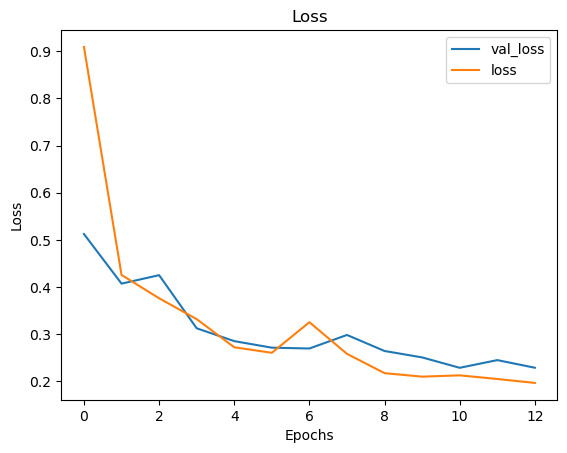

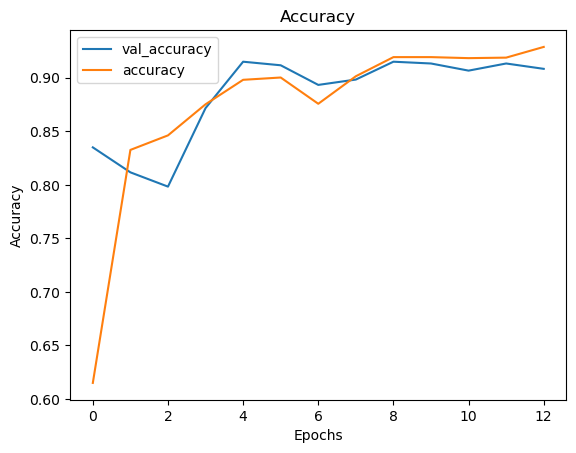

In [78]:
visualize_training_results(model_v6_history)

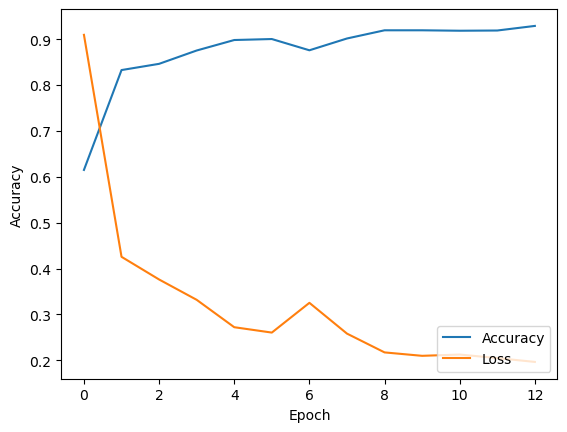

In [79]:
plt.plot(model_v6_history.history['accuracy'])
plt.plot(model_v6_history.history['loss'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Loss'], loc='lower right')

In [80]:
batch_size = 128
num_of_test_samples = 43
predictions = model_v6.predict(test_generator,  num_of_test_samples // batch_size+1)
predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 591ms/step


array([[9.9804723e-01, 1.9313130e-03, 2.1378744e-05],
       [9.9899870e-01, 8.0111035e-04, 2.0021829e-04],
       [9.9714333e-01, 2.8232771e-03, 3.3435648e-05],
       ...,
       [5.9425700e-03, 2.9920650e-04, 9.9375820e-01],
       [5.1154666e-02, 7.0778583e-04, 9.4813752e-01],
       [7.0266360e-01, 2.0315335e-03, 2.9530486e-01]], dtype=float32)

In [81]:
y_pred = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                      precision    recall  f1-score   support

              Forest       0.92      0.94      0.93       400
HerbaceousVegetation       0.94      0.95      0.95       400
             Pasture       0.92      0.89      0.90       400

            accuracy                           0.93      1200
           macro avg       0.93      0.93      0.93      1200
        weighted avg       0.93      0.93      0.93      1200



In [82]:
test_generator.class_indices

{'Forest': 0, 'HerbaceousVegetation': 1, 'Pasture': 2}

In [83]:
cm_labels = list(test_generator.class_indices.keys())
cm_labels

['Forest', 'HerbaceousVegetation', 'Pasture']

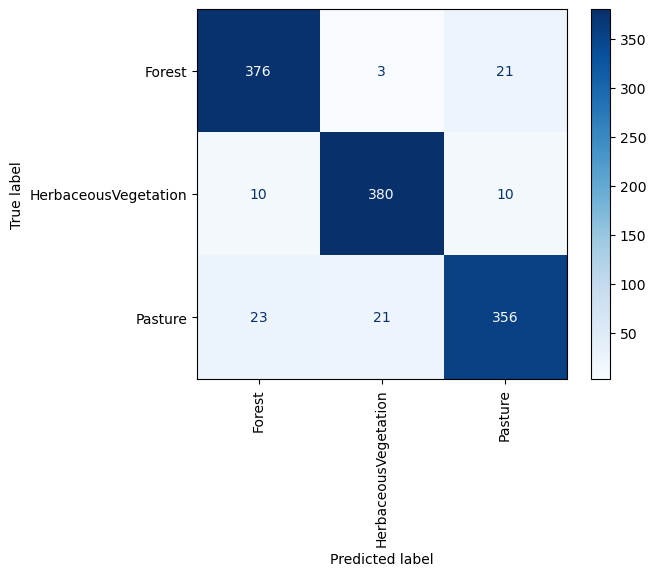

In [84]:
final_disp = ConfusionMatrixDisplay.from_predictions(true_classes, y_pred, 
                                                     display_labels=cm_labels, 
                                                     xticks_rotation="vertical", 
                                                     cmap=plt.cm.Blues)

This confusion matrix shows the performance of the best model (model_v6).
The matrix illustrates which classes the model predicted compared to the actual (true) classes.

### **Structure:**  
**Rows** represent the **true labels**.  
**Columns** represent the **predicted labels**.  
**Diagonal values** (376, 380, 356) are **correctly classified examples**.  
**Off-diagonal values** represent **misclassified examples**.  

The model performs very well because it has high values along the diagonal, which indicates accurate predictions.
It is particularly accurate for "Herbaceous Vegetation" (380/400 = 95%).
Most of the errors occur between "Forest" and "Pasture", which may suggest that these two classes have visual similarities.

**model_v6** is the best model, as it has high accuracy and good generalization.  
The errors are minimal and can be improved through additional data preprocessing


---
## 6. Conclusion

For effective land cover classification, I apply a series of images of the same area taken at different time periods. This approach makes it possible to identify changes in the classification of specific zones, which can serve as an early indicator of impending environmental changes. It is especially important to focus on known wildlife corridors, where the loss of natural habitats can have a significant impact on biodiversity. If changes are detected, such as the replacement of forests with urban areas or agricultural land, this data can be used as a warning of potential land development. Based on this information, timely measures can be taken to prevent deforestation and to protect vital ecosystems that serve as a refuge for rare and endangered species.

## References

1. [DataSet](https://www.kaggle.com/datasets/waseemalastal/eurosat-rgb-dataset)
2. [Convolution (Conv2D Layer)](https://keras.io/api/layers/convolution_layers/convolution2d/)
3. [Max Pooling (MaxPooling2D Layer)](https://www.quora.com/What-is-Max-Pooling-2D)
4. [Loss Function (Categorical Crossentropy)](https://www.v7labs.com/blog/cross-entropy-loss-guide)
5. [Optimization (Adam Optimizer)](https://www.v7labs.com/blog/cross-entropy-loss-guide)
6. [Loss Function (Categorical Crossentropy)](https://www.geeksforgeeks.org/categorical-cross-entropy-in-multi-class-classification)
7. [Early Stopping Criterion](https://cyborgcodes.medium.com/what-is-early-stopping-in-deep-learning-eeb1e710a3cf)
8. [Weight Update (Backpropagation with Adam Optimizer)](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
9. [Batch Training Process](https://www.tooli.qa/insights/batch-processing-the-key-to-making-your-neural-networks-sing)
10. [Accuracy Calculation](https://www.digitalocean.com/community/tutorials/deep-learning-metrics-precision-recall-accuracy)
11. [L1 and L2 Regularization](https://medium.com/@alejandro.itoaramendia/l1-and-l2-regularization-part-1-a-complete-guide-51cf45bb4ade)
12. [Dropout Regularization](https://www.geeksforgeeks.org/dropout-regularization-in-deep-learning/)
13. [Convolution Operation for a Larger Kernel](https://discuss.pytorch.org/t/performing-convolution-with-large-kernels/136381)
14. [Neural Activation in Multiple Dense Layers](https://wandb.ai/ayush-thakur/keras-dense/reports/Keras-Dense-Layer-How-to-Use-It-Correctly--Vmlldzo0MjAzNDY1)
15. [Convolution Operation for Multiple Layers](https://stackoverflow.com/questions/27728531/convolutional-neural-networks-multiple-channels)
16. [Dropout Effect During Inference](https://medium.com/biased-algorithms/the-role-of-dropout-in-neural-networks-fffbaa77eee7)
17. [Neural Activation in Extra Dense Layer](https://community.deeplearning.ai/t/adding-a-dense-layer/189966)
18. [Parameter Growth Due to Extra Dense Layer](https://www.quora.com/Does-adding-more-layers-always-result-in-more-accuracy-in-convolutional-neural-networks)